In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Check column names in station
inspector = inspect(engine)
columns = inspector.get_columns('station')
for x in columns:
    print(x['name'], x['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Check column names in measurement
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for x in columns:
    print(x['name'], x['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()
print(recent_date)

2017-08-23


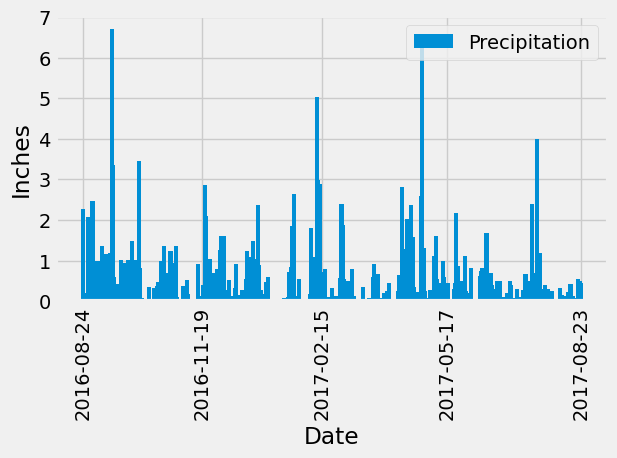

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
specific_date = dt.datetime(2017, 8, 23)
past_year = specific_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(
    measurement.date >= past_year,
    measurement.date <= specific_date
).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.set_index('date', inplace=True)
df.sort_index(ascending=False)
plt.bar(df.index, df['precipitation'], width=3, label='Precipitation')
plt.xticks(ticks=df.index[::max(1, len(df)//4)], rotation=90)
plt.yticks(ticks=range(0,int(df['precipitation'].max())+2))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_data = session.query(measurement.prcp).all()
prcp_df = pd.DataFrame(prcp_data, columns=['precipitation'])

count = prcp_df['precipitation'].count()
mean = prcp_df['precipitation'].mean()
std_dev = prcp_df['precipitation'].std()
p_min = prcp_df['precipitation'].min()
p_max = prcp_df['precipitation'].max()
perc1 = prcp_df['precipitation'].quantile(0.25)
perc2 = prcp_df['precipitation'].quantile(0.50)
perc3 = prcp_df['precipitation'].quantile(0.75)

data = [count, mean, std_dev, p_min, p_max, perc1, perc2, perc3]
index_labels = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

summary = pd.DataFrame(data, index=index_labels, columns=['precipitation'])
summary

,precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,11.530000
50%,0.000000
75%,0.010000
max,0.110000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
total_stations

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_stations = session.query(
    measurement.station, func.count(measurement.station).label('observation_count')
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

for station in most_stations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = 'USC00519281'

low_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active).scalar()
high_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active).scalar()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active).scalar()
                         
print(low_temp, high_temp, avg_temp)

54.0 85.0 71.66378066378067


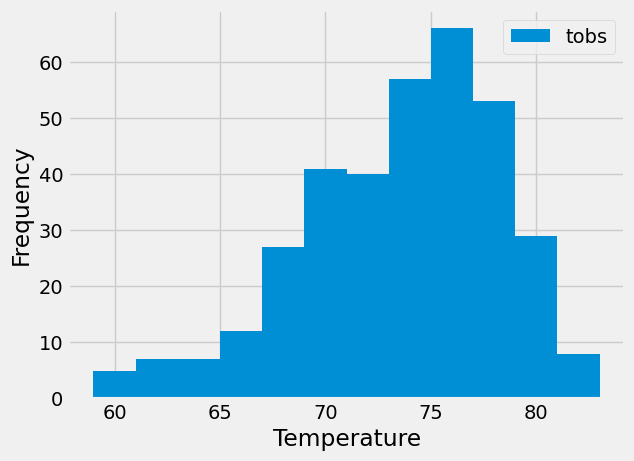

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active = 'USC00519281'

latest_date = session.query(func.max(measurement.date)).scalar()
latest_date = pd.to_datetime(latest_date)
past_year = latest_date - dt.timedelta(days=365)

past_year_str = past_year.strftime('%Y-%m-%d')

query = session.query(measurement.tobs).filter(measurement.station == most_active, 
                                               measurement.date >= past_year_str
).all()

df = pd.DataFrame(query, columns=['tobs'])
df['tobs'].plot(kind='hist', bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [18]:
# Close Session
session.close()